Autoencoder Anomaly Testing
===

This is rebuilt from the "Collecting Network Statistics" notebook. The goal of this notebook is to collect together a set of in-distribution and out-of-distribution images and confirm that the model can distinguish them with a high degree of accuracy.


## Setup

We begin by importing our dependencies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import math

from pytorch_msssim import ssim,ms_ssim,SSIM
from model import SplitAutoencoder,ExtensibleEncoder,ExtensibleDecoder
from CustomDataSet import CustomDataSet,CustomDataSetWithError
from GaussianNoise import AddGaussianNoiseAndRescale,Rescale
import os

from sklearn.metrics import roc_auc_score,roc_curve,auc

import GPUtil

Set our seed and other configurations for reproducibility.

In [2]:
seed = 42
#seed = 2662
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

basis = "training"
distribution = "lesions"

if torch.cuda.is_available():
    platform = "cuda"
else:
    platform = "cpu"
#platform = "cpu"
print(platform)

cuda


We set the batch size, the number of training epochs, and the learning rate. Batch size has to be reasonably low as we can't fit a huge number of these images into VRAM on my laptop.

Image size can be set here as I'm automatically resizing the images in my extraction code.

In [3]:
width = 256
height = 256

image_size = width * height

batch_size = 1

#meta-parameters
l2_decay = 0.0
dropout_rate = 0.1
code_sides = [20]
convolution_filters = 32

model_extension = str(width) + "_" + str(code_sides[0]) + "_" + str(convolution_filters) + "_" + str(dropout_rate) + "_" + str(l2_decay)
full_extension = "_" + basis + "_" + distribution + "_" + model_extension

model_path = "../../Data/OPTIMAM_NEW/model" + full_extension + ".pt"

#image_count = 500
image_count = -1

validation_split = 0.95

## Gather Base Distribution Information

First we run the model on the entire original distribution and gather statistics on the loss values, encodings etc.

In [4]:
from torchvision.transforms import ToTensor,Normalize
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.0,65535.0)
    ])

if distribution=="screening":
    root_dir = "../../Data/OPTIMAM_NEW/png_images/casewise/ScreeningMammography/" + str(width)
else:
    root_dir = "../../Data/OPTIMAM_NEW/png_images/lesions"
train_dataset = CustomDataSet(root_dir, transform)

if (image_count == -1):
    train_dataset_subset = train_dataset
    image_count = len(train_dataset)
else:
    train_dataset_subset = torch.utils.data.Subset(train_dataset, numpy.random.choice(len(train_dataset), image_count, replace=False))

train_subset_idx = np.random.choice(len(train_dataset), int(image_count * validation_split), replace=False)

n = np.arange(len(train_dataset))
mask = np.ones(len(train_dataset), dtype=bool)
mask[train_subset_idx] = False
holdout_subset_idx = n[mask]

dataset_size = len(train_dataset_subset)
      
t_subset = torch.utils.data.Subset(train_dataset_subset, train_subset_idx)

train_loader = torch.utils.data.DataLoader(
    t_subset, batch_size=batch_size, shuffle=False
)

h_subset = torch.utils.data.Subset(train_dataset_subset, holdout_subset_idx)

holdout_loader = torch.utils.data.DataLoader(
    h_subset, batch_size=batch_size, shuffle=False
)

In [5]:
print(train_subset_idx)
print(holdout_subset_idx)

[7856 4112 2521 ...  335 3627  429]
[  27   40   44   59   90  123  183  210  236  237  247  286  381  392
  428  446  467  484  500  598  616  621  623  636  656  665  719  746
  750  791  792  805  816  826  832  852  874  886  927  959  965  973
  978 1020 1039 1052 1108 1129 1215 1234 1239 1275 1303 1306 1338 1339
 1372 1385 1442 1447 1461 1548 1555 1564 1574 1635 1662 1663 1669 1699
 1751 1768 1829 1836 1837 1845 1870 1892 1900 1912 1917 1933 1957 1964
 1969 1978 1981 1984 1986 1990 1991 2036 2048 2095 2126 2149 2152 2167
 2180 2212 2223 2232 2269 2280 2316 2321 2326 2330 2380 2405 2410 2451
 2565 2593 2629 2686 2696 2717 2727 2729 2785 2813 2851 2885 2892 2916
 2932 2942 2964 3014 3015 3018 3069 3157 3165 3184 3185 3205 3210 3217
 3227 3232 3269 3297 3324 3339 3366 3372 3373 3417 3466 3501 3505 3517
 3518 3525 3537 3560 3578 3587 3589 3632 3637 3709 3732 3742 3761 3764
 3805 3821 3851 3881 3887 3921 3971 3980 3983 4023 4053 4057 4071 4092
 4133 4176 4216 4243 4251 4272 4280 4300 

In [6]:
#  use gpu if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device(platform)

code_size = code_sides[0] * code_sides[0]

# mean-squared error loss
criterion = nn.MSELoss()

features = [None] * len(t_subset)
losses = [None] * len(t_subset)
encodings = [None] * len(t_subset)
outputs = [None] * len(t_subset)

In [7]:
# reload the saved model
model = torch.load(model_path,map_location=device)
model.eval()

SplitAutoencoder(
  (encoder): ExtensibleEncoder(
    (cnnStage): Sequential(
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout1): Dropout2d(p=0.0, inplace=True)
      (relu1): ReLU()
      (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout2): Dropout2d(p=0.0, inplace=True)
      (relu2): ReLU()
      (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout3): Dropout2d(p=0.0, inplace=True)
      (relu3): ReLU()
      (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (flatten): Flatten(start_dim=1, end_dim=-1)
    )
    (fc1): Linear(in_features=131072, out_features=400, bias=True)
  )
  (decoder): ExtensibleDecoder(
    (cnnStage): Sequential(


We run our autoencoder on the entire dataset and store the encodings

In [8]:
with torch.no_grad():
    count = 0
    for batch_features in train_loader:
        # load it to the active device
        batch_features = batch_features.to(device)

        features[count] = batch_features.cpu()
        
        # compute reconstructions
        code = model.encoder(batch_features)
        output = model.decoder(code)
        
        outputs[count] = output.cpu()
        
        code_reshaped = code.detach().cpu().numpy()[0]
        code_reshaped.reshape(code_size)

        encodings[count] = code_reshaped

        # compute training reconstruction loss
        error_criterion = criterion(output,batch_features)

        losses[count] = error_criterion.cpu().numpy()

        count = count + 1

C:\Users\chali\Miniconda3\envs\pytorch\lib\site-packages\torchvision\transforms\functional.py:92: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  img = torch.from_numpy(np.array(pic, np.float32, copy=False))
C:\Users\chali\Miniconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:3060: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "


And calculate the encoding statistics:

In [9]:
encodings_n = np.stack(encodings)
encodings_t = torch.from_numpy(encodings_n)
encodings_mean = torch.mean(encodings_t,0)

encodings_mean_np = encodings_mean.numpy()
print(encodings_n)
encodings_covariance = np.cov(encodings_n.T)
print(encodings_covariance)
encodings_inv_covariance = np.linalg.inv(encodings_covariance)

[[ -0.20508611  12.684079    -4.537349   ...   4.5549607   -1.4616698
   18.732637  ]
 [  5.6738205   -6.312059    -7.0872526  ...   2.111087    13.061634
   -5.5737257 ]
 [ -3.968779    -3.0219016  -13.110109   ...   7.5378213   -3.8181288
    9.397114  ]
 ...
 [ 10.834586     1.6583242    5.3399396  ...  10.465675    10.546119
    5.443666  ]
 [  1.4226435   18.314531     1.6266955  ...   2.196095    -0.38130796
   13.77939   ]
 [ -4.4359555   -3.9636192   24.144331   ...   7.8097405   -4.244827
    2.904443  ]]
[[ 81.14233007   2.75852639   0.39314651 ...  -9.24657956   5.18268653
    0.99985277]
 [  2.75852639  80.74884986   8.86630395 ...   9.93809097   0.70442943
    5.4987678 ]
 [  0.39314651   8.86630395 110.02739483 ...   5.09872554   1.38243075
    3.33937804]
 ...
 [ -9.24657956   9.93809097   5.09872554 ...  45.84399776  -1.38762587
    5.699019  ]
 [  5.18268653   0.70442943   1.38243075 ...  -1.38762587  74.9127668
   -0.66044084]
 [  0.99985277   5.4987678    3.33937804 

In [10]:
mse_min = np.amin(losses)
mse_max = np.amax(losses)
mse_mean = np.mean(losses)
mse_std = np.std(losses)
print("MSE Min/Mean/Max/SD:" + str(mse_min) + "/" + str(mse_mean) + "/" + str(mse_max) + "/" + str(mse_std)   )

MSE Min/Mean/Max/SD:0.00014059251/0.0011199235/0.003736041/0.00047129215


In [11]:
features_n = np.stack(features)
outputs_n = np.stack(outputs)
print(features_n.shape)
print(outputs_n.shape)

pre_ssims = [None] * len(encodings)

ssim_module = SSIM(data_range=1.0, size_average=False, channel=3)

for i in range(len(encodings)):
    features_s = features_n[i].reshape(1,1,height,width).repeat(3,1)
    outputs_s = outputs_n[i].reshape(1,1,height,width).repeat(3,1)
    ssim_f = ssim_module(torch.from_numpy(features_s), torch.from_numpy(outputs_s))
    pre_ssims[i] = ssim_f.item()
    
ssim_min = np.amin(pre_ssims)
ssim_max = np.amax(pre_ssims)
ssim_mean = np.mean(pre_ssims)
ssim_sd = np.std(pre_ssims)
print("SSIM Min/Mean/Max/SD:" + str(ssim_min) + "/" + str(ssim_mean) + "/" + str(ssim_max) + "/" + str(ssim_sd))

(8336, 1, 1, 256, 256)
(8336, 1, 1, 256, 256)
SSIM Min/Mean/Max/SD:0.2999132573604584/0.863186739306475/0.9806013107299805/0.05963395691431509


Now we save the compiled statistics to an excel file.

In [12]:
with torch.no_grad():
    np_losses = np.asarray(losses)
    np_pre_ssims = np.asarray(pre_ssims)
    np_compiled = np.concatenate((np_losses[:, np.newaxis], encodings), axis=1)

    suffix = full_extension
    
    np.savetxt('base_encodings' + suffix + '.csv', encodings, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('base_losses' + suffix + '.csv', np_losses, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('base_ssim' + suffix + '.csv', np_pre_ssims, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('base_combined' + suffix + '.csv', np_compiled, delimiter=',',fmt='%10.5f',newline='\n')

## Adversarials

We have 2 Datasets (mammographic and non-mammographic) and 3 DataLoaders - Clean Mammo, Distorted Mammo, and Non-Mammo. The goal here is to build an analogously large set of OOD images and test to what degree the autoencoder is capable of detecting the distortions.

The first method for doing this builds a large set of all the datasets classified into In-Distribution and Out-Of-Distribution and determine the accuracy rating of the model as a classifier. The second generates a set of distorted mammographic images at specified distances from the distribution, along with a value roughly analogous to that distortion level. This second method is intended to determine the range in distribution space at which the model becomes able to distinguish, as well as the degree of "grey area" between in and out of distribution (as detected).

In [13]:
with torch.no_grad():
    trigger_chance = 0.4

    PIL_transforms = torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=10,translate=(0.2,0.2),shear=25),
        torchvision.transforms.RandomVerticalFlip(),
        torchvision.transforms.RandomHorizontalFlip(),
#        torchvision.transforms.GaussianBlur(kernel_size=3)
        ],p=trigger_chance)
    
    tensor_transforms = torchvision.transforms.RandomApply([
        torchvision.transforms.RandomErasing(p=1.0,value=torch.rand(1).item()),
        torchvision.transforms.Lambda(lambda x : x + (torch.randn_like(x) * 0.001))
#        AddGaussianNoiseAndRescale(0.0,0.2)
        ],p=trigger_chance)

    adversarial_transform = torchvision.transforms.Compose([        
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(0.0,65535.0),
        PIL_transforms,
        tensor_transforms,
        Rescale()
        ])
   
    adversarial_image_count = image_count
    adversarial_dataset = CustomDataSetWithError(root_dir, adversarial_transform)
    
    if(basis == "holdout"): 
        a_subset = torch.utils.data.Subset(adversarial_dataset, holdout_subset_idx)
    else:
        a_subset = torch.utils.data.Subset(adversarial_dataset, train_subset_idx)

    adversarial_loader = torch.utils.data.DataLoader(
        a_subset,shuffle=True
    )
    
    

Build the first (mixed) set:

In [14]:
with torch.no_grad():
    adversarial_iterator = iter(adversarial_loader)
    genuine_iterator = iter(holdout_loader)
    mixed_set_scale = 300
    
    mixed_set = []
    mixed_set_np = []
    mixed_class_set = []
    mixed_error_set = []
    for i in range(mixed_set_scale):
        r = torch.rand(1)
        if(r.item() > 0.5):
            error = 0.0
            while(error==0.0):
                try:
                    adversarial_t = next(adversarial_iterator)
                    adversarial = adversarial_t[0].cpu()
                    adversarial_np = adversarial.numpy().reshape(width,height)
                    error = adversarial_t[1].item()
                except StopIteration:
                    adversarial_iterator = iter(adversarial_loader)
            mixed_class_set.append(1) # positive class, since we're trying to detect adversarials
            mixed_set_np.append(adversarial_np)
            mixed_set.append(adversarial)
            mixed_error_set.append(error)
            print("Positive: Min " + str(np.amin(adversarial_np)) + " Max " + str(np.amax(adversarial_np)) + " Error " + str(error))
        else:
            genuine = next(genuine_iterator).cpu()
            genuine_np = genuine.numpy().reshape(width,height)
            mixed_class_set.append(0) # negative class
            mixed_set.append(genuine)
            mixed_set_np.append(genuine_np)
            mixed_error_set.append(0.0) # genuine, so no drift
            print("Negative: Min " + str(np.amin(genuine_np)) + " Max " + str(np.amax(genuine_np)) + " Error 0.0")
        
    mixed_code_set = []
    mixed_code_np_set = []
    mixed_reconstruction_set = []
    mixed_losses = []

Positive: Min 0.0 Max 1.0 Error 0.030206061899662018
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.027005519717931747
Positive: Min 0.0 Max 1.0 Error 0.03779938071966171
Positive: Min 0.0 Max 1.0 Error 0.05288933962583542
Negative: Min 0.0 Max 1.0 Error 0.0
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.0645248144865036
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.08270500600337982
Positive: Min 0.0 Max 1.0 Error 0.03699161857366562
Positive: Min 0.0 Max 1.0 Error 0.06239210069179535
Positive: Min 0.0 Max 1.0 Error 0.04299946501851082
Positive: Min 0.0 Max 1.0 Error 0.32117998600006104
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.10575487464666367
Positive: Min 0.0 Max 1.0 Error 0.03192625939846039
Positive: Min 0.0 Max 1.0 Error 0.037725985050201416
Positive: Min 0.0 Max 1.0 Error 0.22917860746383667
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.0013684649020433426


C:\Users\chali\Miniconda3\envs\pytorch\lib\site-packages\torchvision\transforms\functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")



Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.056701675057411194
Negative: Min 0.0 Max 1.0 Error 0.0
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.050645146518945694
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.20981213450431824
Positive: Min 0.0 Max 1.0 Error 0.014044276438653469
Positive: Min 0.0 Max 1.0 Error 0.08811899274587631
Negative: Min 0.0 Max 1.0 Error 0.0
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.010734431445598602
Positive: Min 0.0 Max 1.0 Error 0.029697228223085403
Negative: Min 0.0 Max 1.0 Error 0.0
Negative: Min 0.0 Max 1.0 Error 0.0
Positive: Min 0.0 Max 1.0 Error 0.014828605577349663
Positive: Min 0.0 Max 1.0 Error 0.009001377038657665
Positive: Min 0.0 Max 1.0 Error 0.020182553678750992
Positive: Min 0.0 Max 1.0 Error 0.03369806706905365
Positive: Min 0.0 Max 1.0 Error 0.03017929196357727
Positive: Min 0.0 Max 1.0 Error 0.06204863637685776
Negative: Min 0.0 Max 1.0 E

Now run the model on the mixed set:

In [15]:
with torch.no_grad():
    count = 0
    for mixed_item in mixed_set:
        mixed_example = mixed_item.to(device)
        
        n_code = model.encoder(mixed_example)
        reconstruction = model(mixed_example)
        
        mixed_code_set.append(n_code.cpu())
        mixed_code_np_set.append(n_code.cpu().numpy())
        mixed_reconstruction_set.append(reconstruction.cpu())
        
        error_criterion = criterion(reconstruction,mixed_example)
        loss = error_criterion.cpu().numpy()
        mixed_losses.append(loss)

Next, measure the loss and feature statistics for the adversarials:            

#### Mean Squared Error (MSE):

First calculate the MSE for all the reconstructed images.

In [16]:
mixed_losses_np = np.asarray(mixed_losses)
post_mse_min = np.amin(mixed_losses_np)
post_mse_max = np.amax(mixed_losses_np)
post_mse_mean = np.mean(mixed_losses_np)
post_mse_std = np.std(mixed_losses_np)
print("Prediction MSE Min/Mean/Max/SD:" + str(post_mse_min) + "/" + str(post_mse_mean) + "/" + str(post_mse_max) + "/" + str(post_mse_std))

Prediction MSE Min/Mean/Max/SD:0.00018775529/0.011561689/0.17672373/0.021345874


And attempt to predict classes based on MSE:

In [17]:
mse_threshold = mse_mean + (2 * mse_std)

predicted_class = []
for i in range(mixed_set_scale):
    if(mixed_losses_np[i]<mse_threshold):
        predicted_class.append(0) # distribution
    else:
        predicted_class.append(1) # adversarial

mixed_class_np = np.asarray(mixed_class_set)
predicted_class_np = np.asarray(predicted_class)
print(mixed_class_np)
print(predicted_class_np)

tp = np.sum(mixed_class_np * predicted_class_np)
tn = np.sum((1 - mixed_class_np) * (1 - predicted_class_np))
fp = np.sum((1 - mixed_class_np) * predicted_class_np)
fn = np.sum(mixed_class_np * (1 - predicted_class_np))

hits = tn + tp
accuracy = hits / mixed_set_scale
print("Accuracy:" + str(accuracy))

precision = tp / (tp+fp)
recall = tp / (tp+fn)

f1_score = 2 * ((precision * recall) / (precision + recall))

print("Precision:" + str(precision))
print("Recall:" + str(recall))
print("F1:" + str(f1_score))

fails = np.where(mixed_class_np != predicted_class_np)
print(fails)

[1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1
 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0
 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1
 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0
 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0
 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1
 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1
 1 1 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 0
 0 0 0 0]
[1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1
 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0
 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1
 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0
 0 0 0 1 0 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0
 1 0 0 1 0 1 0 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[0.         0.         0.         0.02255639 0.02255639 0.03007519
 0.03007519 0.03759398 0.03759398 0.04511278 0.04511278 0.07518797
 0.07518797 0.08270677 0.08270677 0.4887218  0.4887218  0.64661654
 0.64661654 1.        ]
[0.         0.00598802 0.95209581 0.95209581 0.95808383 0.95808383
 0.96407186 0.96407186 0.97005988 0.97005988 0.9760479  0.9760479
 0.98203593 0.98203593 0.98802395 0.98802395 0.99401198 0.99401198
 1.         1.        ]
[1.1767237e+00 1.7672373e-01 2.6329332e-03 2.4060071e-03 2.4013421e-03
 2.3558540e-03 2.3401454e-03 2.3385121e-03 2.3355701e-03 2.3105827e-03
 2.2562705e-03 2.1628537e-03 2.0335056e-03 1.9713650e-03 1.9088405e-03
 1.2339682e-03 1.2150891e-03 1.0647508e-03 1.0646229e-03 1.8775529e-04]


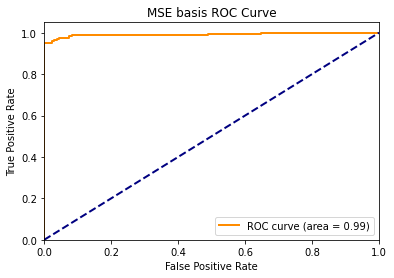

In [18]:
fpr, tpr, thresh = roc_curve(mixed_class_np, mixed_losses_np)
roc_auc = auc(fpr, tpr)
print(fpr)
print(tpr)
print(thresh)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MSE basis ROC Curve')
plt.legend(loc="lower right")

out_path = "mse_roc_graph_output" + full_extension + ".eps"
plt.savefig(out_path)
plt.show()

#### STRUCTURAL SIMILARITY INDEX (SSIM)

Generate RGB versions of the base and recreated images.

In [19]:
mixed_set_s = np.stack(mixed_set).reshape(mixed_set_scale,1,height,width).repeat(3,1)
mixed_recon_s = np.stack(mixed_reconstruction_set).reshape(mixed_set_scale,1,height,width).repeat(3,1)
print(mixed_set_s.shape)
print(mixed_recon_s.shape)

(300, 3, 256, 256)
(300, 3, 256, 256)


And use that for Structural Similarity Index:

In [20]:
ssim_t = ssim(torch.from_numpy(mixed_set_s), torch.from_numpy(mixed_recon_s), data_range=1.0, size_average = False)
ms_ssim_t = ms_ssim(torch.from_numpy(mixed_set_s), torch.from_numpy(mixed_recon_s), data_range=1.0, size_average = False)

In [21]:
post_ssim_min = np.amin(ssim_t.numpy())
post_ssim_max = np.amax(ssim_t.numpy())
post_ssim_mean = np.mean(ssim_t.numpy())
post_ssim_std = np.std(ssim_t.numpy())
print("Prediction SSIM Min/Mean/Max/SD:" + str(post_ssim_min) + "/" + str(post_ssim_mean) + "/" + str(post_ssim_max) + "/" + str(post_ssim_std))

Prediction SSIM Min/Mean/Max/SD:0.16103221/0.70384806/0.96024173/0.17945455


In [22]:
with torch.no_grad():
    np_post_losses = np.asarray(mixed_losses_np)
    np_post_ssims = np.asarray(ssim_t)
    np_distances = np.asarray(mixed_error_set)
    
    suffix = full_extension
    
    np.savetxt('mixed_losses' + suffix + '.csv', np_post_losses, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('mixed_ssim' + suffix + '.csv', np_post_ssims, delimiter=',',fmt='%10.5f',newline='\n')
    np.savetxt('mixed_distance' + suffix + '.csv', np_distances, delimiter=',',fmt='%10.5f',newline='\n')

Attempt to predict the class based on the SSIM:

In [23]:
ssim_threshold = ssim_mean - (2 * ssim_sd)
#ssim_threshold = ssim_min
predicted_class_ssim = []
for i in range(mixed_set_scale):
    if(ssim_t[i]>ssim_threshold):
        predicted_class_ssim.append(0) # distribution
    else:
        predicted_class_ssim.append(1) # adversarial

predicted_class_ssim_np = np.asarray(predicted_class_ssim)
print(mixed_class_np)
print(predicted_class_ssim_np)
tp_ssim = np.sum(mixed_class_np * predicted_class_ssim_np)
tn_ssim = np.sum((1 - mixed_class_np) * (1 - predicted_class_ssim_np))
fp_ssim = np.sum((1 - mixed_class_np) * predicted_class_ssim_np)
fn_ssim = np.sum(mixed_class_np * (1 - predicted_class_ssim_np))

hits_ssim = tn_ssim + tp_ssim
accuracy_ssim = hits_ssim / mixed_set_scale
print("Accuracy:" + str(accuracy_ssim))

precision_ssim = tp_ssim / (tp_ssim+fp_ssim)
recall_ssim = tp_ssim / (tp_ssim+fn_ssim)

f1_score_ssim = 2 * ((precision_ssim * recall_ssim) / (precision_ssim + recall_ssim))

print("Precision:" + str(precision_ssim))
print("Recall:" + str(recall_ssim))
print("F1:" + str(f1_score_ssim))

[1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1
 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0
 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1
 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0
 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0
 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1
 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1
 1 1 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 0
 0 0 0 0]
[1 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1
 1 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 1 1
 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0
 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0
 1 0 0 1 0 1 0 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[0.         0.         0.         0.0075188  0.0075188  0.01503759
 0.01503759 0.02255639 0.02255639 0.03759398 0.03759398 0.05263158
 0.05263158 0.06015038 0.06015038 0.09774436 0.09774436 0.11278195
 0.11278195 0.12030075 0.12030075 0.12781955 0.12781955 0.15037594
 0.15037594 0.22556391 0.22556391 0.2481203  0.2481203  0.27819549
 0.27819549 0.28571429 0.28571429 0.33834586 0.33834586 0.36842105
 0.36842105 0.39849624 0.39849624 0.59398496 0.59398496 0.62406015
 0.62406015 0.72180451 0.72180451 0.76691729 0.76691729 0.82706767
 0.82706767 0.84210526 0.84210526 0.87218045 0.87218045 1.        ]
[0.         0.00598802 0.44311377 0.44311377 0.67065868 0.67065868
 0.77844311 0.77844311 0.83832335 0.83832335 0.84431138 0.84431138
 0.8502994  0.8502994  0.86227545 0.86227545 0.86826347 0.86826347
 0.8742515  0.8742515  0.88023952 0.88023952 0.89820359 0.89820359
 0.90419162 0.90419162 0.91017964 0.91017964 0.91616766 0.91616766
 0.92215569 0.92215569 0.92814371 0.92814371 0.93413174 0.934

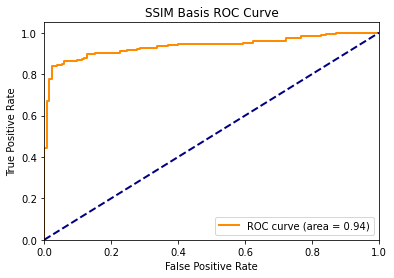

In [24]:
#confidence value for roc curve is 1-SSIM errpr (ie, for extremely high error we are less sure)
fpr, tpr, thresh = roc_curve(mixed_class_np, 1 - ssim_t)
roc_auc = auc(fpr, tpr)
print(fpr)
print(tpr)
print(thresh)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SSIM Basis ROC Curve')
plt.legend(loc="lower right")

out_path = "ssim_roc_graph_output" + full_extension + ".eps"
plt.savefig(out_path)
plt.show()

#### Mahalanobis Distance

We calculate the Mahalanobis distance for every result in the set.

In [39]:
with torch.no_grad():
    mahalanobis_set = []
    for i in range(len(mixed_code_set)):
        code = mixed_code_np_set[i]
        x_minus_mu =  code - encodings_mean_np
        left_term = np.dot(x_minus_mu, encodings_inv_covariance)
        mahal = np.dot(left_term, x_minus_mu.T)
        m = mahal.diagonal()
        
        mahalanobis_set.append(m)
    mahalanobis_set_np = np.stack(mahalanobis_set)
    print(mahalanobis_set)

[array([360.49948625]), array([408.90240293]), array([570.00157551]), array([696.30415162]), array([803.72702604]), array([286.17535584]), array([303.26397202]), array([841.93439109]), array([435.69620795]), array([417.69482685]), array([551.44641337]), array([686.47834842]), array([806.81878709]), array([571.96386748]), array([783.9167851]), array([301.77421777]), array([500.63424087]), array([372.67099902]), array([1803.76226003]), array([640.86468557]), array([316.39278522]), array([732.4899556]), array([281.48277249]), array([367.81603283]), array([440.30204643]), array([389.53452185]), array([380.65526723]), array([503.60774545]), array([328.05220776]), array([643.19225161]), array([758.38755335]), array([506.45934702]), array([465.44591173]), array([443.9828862]), array([440.68141724]), array([301.50931453]), array([529.6054769]), array([212.72134552]), array([358.26517552]), array([313.59006154]), array([606.65088817]), array([613.83238275]), array([401.99889872]), array([475.71

In [41]:
mahal_threshold = 240
#ssim_threshold = ssim_min
predicted_class_mahal = []
for i in range(mixed_set_scale):
    if(mahalanobis_set[i]<mahal_threshold):
        predicted_class_mahal.append(0) # distribution
    else:
        predicted_class_mahal.append(1) # adversarial

predicted_class_mahal_np = np.asarray(predicted_class_mahal)
print(mixed_class_np)
print(predicted_class_mahal_np)
tp_mahal = np.sum(mixed_class_np * predicted_class_mahal_np)
tn_mahal = np.sum((1 - mixed_class_np) * (1 - predicted_class_mahal_np))
fp_mahal = np.sum((1 - mixed_class_np) * predicted_class_mahal_np)
fn_mahal = np.sum(mixed_class_np * (1 - predicted_class_mahal_np))

hits_mahal = tn_mahal + tp_mahal
accuracy_mahal = hits_mahal / mixed_set_scale
print("Accuracy:" + str(accuracy_mahal))

precision_mahal = tp_mahal / (tp_mahal+fp_mahal)
recall_mahal = tp_mahal / (tp_mahal+fn_mahal)

f1_score_mahal = 2 * ((precision_mahal * recall_mahal) / (precision_mahal + recall_mahal))

print("Precision:" + str(precision_mahal))
print("Recall:" + str(recall_mahal))
print("F1:" + str(f1_score_mahal))

[1 0 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1
 1 0 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1 0
 0 1 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 0 0 1 1
 0 1 1 1 0 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0
 0 0 0 1 0 0 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 0 0 0
 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1
 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1
 1 1 1 1 0 0 1 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 1 0 0 0 0
 0 0 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


[0.         0.         0.         0.0075188  0.0075188  0.01503759
 0.01503759 0.02255639 0.02255639 0.03007519 0.03007519 0.05263158
 0.05263158 0.06766917 0.06766917 0.07518797 0.07518797 0.08270677
 0.08270677 0.12781955 0.12781955 0.15037594 0.15037594 0.15789474
 0.15789474 0.16541353 0.16541353 0.18045113 0.18045113 0.18796992
 0.18796992 0.20300752 0.20300752 0.21804511 0.21804511 0.2406015
 0.2406015  0.2481203  0.2481203  0.27067669 0.27067669 0.28571429
 0.28571429 0.29323308 0.29323308 0.30075188 0.30075188 0.31578947
 0.31578947 0.33082707 0.33082707 0.33834586 0.33834586 0.34586466
 0.34586466 0.35338346 0.35338346 0.36090226 0.36090226 0.36842105
 0.36842105 0.38345865 0.38345865 0.39849624 0.39849624 0.40601504
 0.40601504 0.44360902 0.44360902 0.45864662 0.45864662 0.48120301
 0.48120301 0.4887218  0.4887218  0.4962406  0.4962406  0.52631579
 0.52631579 0.53383459 0.53383459 0.55639098 0.55639098 0.56390977
 0.56390977 0.57142857 0.57142857 0.58646617 0.58646617 0.60150

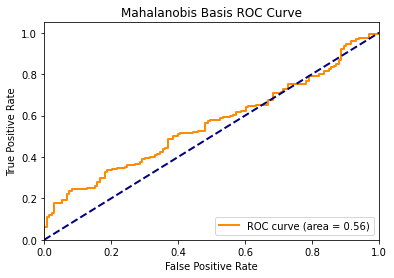

In [37]:
fpr, tpr, thresh = roc_curve(mixed_class_np, mahalanobis_set)
roc_auc = auc(fpr, tpr)
print(fpr)
print(tpr)
print(thresh)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mahalanobis Basis ROC Curve')
plt.legend(loc="lower right")

out_path = "mahal_roc_graph_output" + full_extension + ".eps"
plt.savefig(out_path)
plt.show()

## Plot Outputs

And plot the first 10 results:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(300, 256, 256, 3)
(300, 256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(256, 256, 3)


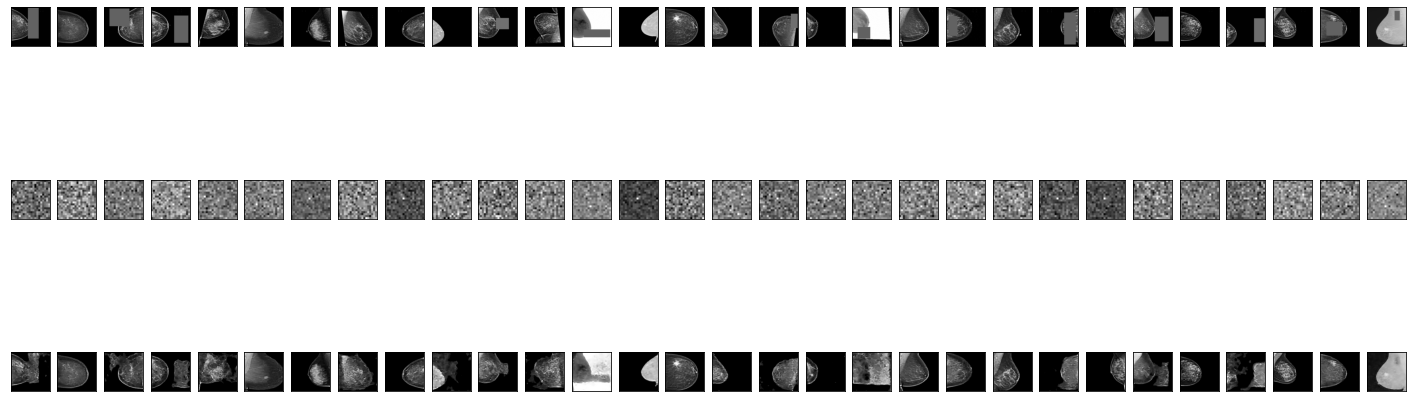

In [42]:
with torch.no_grad():
    mixed_set_g = np.stack(mixed_set).reshape(mixed_set_scale,height,width,1).repeat(3,3)
    mixed_recon_g = np.stack(mixed_reconstruction_set).reshape(mixed_set_scale,height,width,1).repeat(3,3)
    print(mixed_set_g.shape)
    print(mixed_recon_g.shape)

    #number = mixed_set_scale
    number = 30
    plt.figure(figsize=(25, 9))
    for index in range(number):
        # display original
        ax = plt.subplot(3, number, index + 1)
        test_examples = mixed_set_g
        copyback = test_examples[index]
        print(copyback.shape)
        plt.imshow(copyback)
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display codes
        ax = plt.subplot(3, number, index + number + 1)
        codes = mixed_code_set
        code_copyback = codes[index].cpu()
        plt.imshow(code_copyback.reshape(code_sides[0],code_sides[0]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(3, number, index + (number*2) + 1)
        reconstruction = mixed_recon_g
        recon_copyback = reconstruction[index]
        plt.imshow(recon_copyback)
        #plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    out_path = "adv_output" + full_extension + ".png"
    plt.savefig(out_path)
    plt.show()

And plot the failures from the MSE calculation:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(256, 256, 3)
(256, 256, 3)


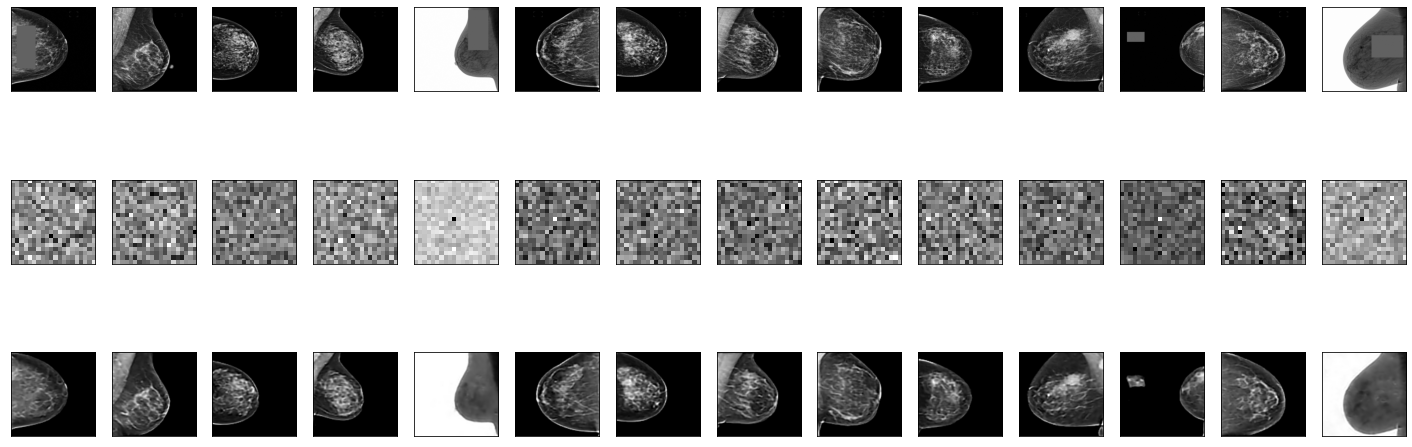

In [43]:
with torch.no_grad():
    if(len(fails[0])<30):
        #number = mixed_set_scale
        number = len(fails[0])
        plt.figure(figsize=(25, 9))
        for index in range(number):
            image_index = fails[0][index]
            # display original
            ax = plt.subplot(3, number, index + 1)
            test_examples = mixed_set_g
            copyback = test_examples[image_index]
            print(copyback.shape)
            plt.imshow(copyback)
            #plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display codes
            ax = plt.subplot(3, number, index + number + 1)
            codes = mixed_code_set
            code_copyback = codes[image_index].cpu()
            plt.imshow(code_copyback.reshape(code_sides[0],code_sides[0]))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

            # display reconstruction
            ax = plt.subplot(3, number, index + (number*2) + 1)
            reconstruction = mixed_recon_g
            recon_copyback = reconstruction[image_index]
            plt.imshow(recon_copyback)
            #plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

        out_path = "fail_output" + full_extension + ".png"
        plt.savefig(out_path)
        plt.show()

Finally, plot projected error against reconstructed MSE:

In [44]:
pred_1 = np.where(predicted_class_np != 0)
pred_0 = np.where(predicted_class_np == 0)

mixed_error_set_np = np.asarray(mixed_error_set)
mixed_error_0 = mixed_error_set_np[pred_0]
mixed_error_1 = mixed_error_set_np[pred_1]

post_losses_0 = np_post_losses[pred_0]
post_losses_1 = np_post_losses[pred_1]

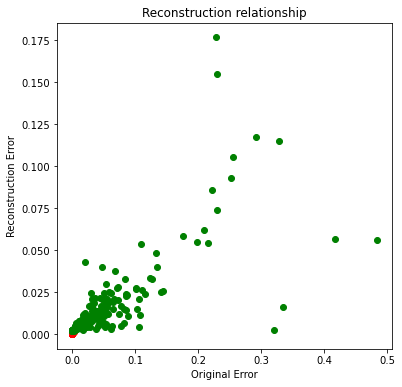

In [45]:
plt.figure(figsize=(6,6))
plt.title('Reconstruction relationship')
plt.xlabel('Original Error')
plt.ylabel('Reconstruction Error')
plt.plot(mixed_error_0, post_losses_0, 'o', color='red');
plt.plot(mixed_error_1, post_losses_1, 'o', color='green');
out_path = "graph_output" + full_extension + ".eps"
plt.savefig(out_path)